# Multi-resolution Analysis

In [1]:
import sys
import math
from pathlib import Path
import pydmd
import numpy as np
from eztrack import (
    preprocess_ieeg,
    lds_raw_fragility,
)
from eztrack.io import read_derivative_npy
from eztrack.utils import warn, Normalize
from eztrack.fragility import SystemIDModel, StructuredPerturbationModel
from mne_bids import read_raw_bids, BIDSPath, get_entity_vals
from mne import concatenate_raws
sys.path.append('../../')

from sickkids.fragility.run_fragility_analysis import run_analysis

%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import mne
# mne.viz.set_3d_backend("notebook")

In [3]:
# %gui qt
# %matplotlib qt
%matplotlib inline

In [4]:
def preprocess_data(bids_path, reference, deriv_path=None, figures_path=None, verbose=True, overwrite=False):
    subject = bids_path.subject

    # set where to save the data output to
    if deriv_path is None:
        deriv_path = (
                bids_path.root
                / "derivatives"
                / "1000Hz"
                / "fragility"
                / reference
                / f"sub-{subject}"
        )
    if figures_path is None:
        figures_path = (
                bids_path.root
                / "derivatives"
                / "figures"
                / "1000Hz"
                / "fragility"
                / reference
                / f"sub-{subject}"
        )

    # use the same basename to save the data
    deriv_basename = bids_path.basename

    # if len(list(deriv_path.rglob(f'{deriv_basename}*'))) > 0 and not overwrite:
    #     warn('Need to set overwrite to True if you want '
    #          f'to overwrite {deriv_basename}')
    #     return

    # load in the data
    raw = read_raw_bids(bids_path, verbose=False)
#     print(raw.ch_names)
    raw = raw.pick_types(seeg=True, ecog=True, eeg=True, misc=False, exclude=[])
#     print(raw.ch_names)
    raw.load_data()
    raw.drop_channels(raw.info['bads'])
#     print(raw.ch_names)

    # pre-process the data using preprocess pipeline
    datatype = bids_path.datatype
    print('Power Line frequency is : ', raw.info["line_freq"])
    raw = preprocess_ieeg(raw,
#                           l_freq=0.5,
                          h_freq=500,
                         verbose=verbose, method="simple", drop_chs=False)
#     print(raw.ch_names)
#     raw = raw.pick_types(seeg=True, ecog=True, eeg=True, misc=True, exclude=[])
    return raw

In [5]:
# the root of the BIDS dataset
root = Path("/Users/adam2392/OneDrive - Johns Hopkins/sickkids/")

# define BIDS entities
subjects = [
    "E1",
    # 'E2',
    # 'E3',
#     'E4',
    # 'E5', 'E6'
]

session = "postsurgery"  # only one session

# pre, Sz, Extraoperative, post
# task = "pre"
acquisition = "ecog"
datatype = "ieeg"
extension = ".vhdr"

# analysis parameters
reference = 'average'

sessions = [
    'extraoperative',
    'preresection',
    'intraresection',
    'postresection']

raws = []
postraws = []

# get the runs for this subject
subjects = get_entity_vals(root, "subject")
for subject in subjects:
    if subject != 'E4':
        continue
    ignore_subs = [sub for sub in subjects if sub != subject]
    sessions = get_entity_vals(root, 'session', ignore_subjects=ignore_subs)
    
    for session in sessions:
        ignore_sessions = [ses for ses in sessions if ses != session]
        ignore_set = {
            'ignore_subjects': ignore_subs,
            'ignore_sessions': ignore_sessions,
        }
        all_tasks = get_entity_vals(root, "task", **ignore_set)
        tasks = all_tasks
        # tasks = ['pre']

        for task in tasks:
            print(f"Analyzing {task} task.")
            ignore_tasks = [tsk for tsk in all_tasks if tsk != task]
            ignore_set['ignore_tasks'] = ignore_tasks
            runs = get_entity_vals(
                root, 'run', **ignore_set
            )
#             print(ignore_subs)
#             print(ignore_tasks)
#             print(f'Found {runs} runs for {task} task.')

            for idx, run in enumerate(runs):
                # create path for the dataset
                bids_path = BIDSPath(
                    subject=subject,
                    session=session,
                    task=task,
                    run=run,
                    datatype=datatype,
                    acquisition=acquisition,
                    suffix=datatype,
                    root=root,
                    extension=extension,
                )
                print(f"Analyzing {bids_path}")

                raw = preprocess_data(bids_path, reference=reference)
        
                break
            break
        if session in ['intraresection', 'postresection']:
            postraws.append(raw)
        else:
            raws.append(raw)
#         break
    break

Analyzing ictal task.
Analyzing /Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/ses-extraoperative/ieeg/sub-E4_ses-extraoperative_task-ictal_acq-ecog_run-01_ieeg.vhdr


<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: Did not find any events.tsv associated with sub-E4_ses-extraoperative_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/**/sub-E4_ses-extraoperative*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C4', 'C5', 'C6', 'C7', 'C8', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'F2AL1', 'F2AL2', 'F2AL3', 'F2AL4', 'F2AL5', 'F2AL6', 'F2BC1', 'F2BC2', 'F2BC3', 'F2BC4', 'F2BC5', 'F2BC6', 'F2CL1', 'F2CL2', 'F2CL3', 'F2CL4', 'F2CL5', 'F2CL6', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89'

Power Line frequency is :  60
Analyzing post task.
Analyzing /Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/ses-postresection/ieeg/sub-E4_ses-postresection_task-post_acq-ecog_run-01_ieeg.vhdr


<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: Did not find any events.tsv associated with sub-E4_ses-postresection_task-post_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/**/sub-E4_ses-postresection*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C6', 'C7', 'C8', 'C14', 'C15', 'C16', 'C21', 'C22', 'C23', 'C24', 'C29', 'C30', 'C31', 'C32', 'C37', 'C38', 'C39', 'C40', 'C43', 'C44', 'C45', 'C46', 'C48', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'C100', 'C101', 'C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108', 'C109', 'C110', 'C111', 'C112', 'C113', 'C114', 'C115', 'C116', 'C117', 'C118', 'C119', 'C120', 'C121',

Power Line frequency is :  60
Analyzing pre task.
Analyzing /Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/ses-preresection/ieeg/sub-E4_ses-preresection_task-pre_acq-ecog_run-01_ieeg.vhdr


<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: Did not find any events.tsv associated with sub-E4_ses-preresection_task-pre_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/**/sub-E4_ses-preresection*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C4', 'C5', 'C6', 'C7', 'C8', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'F2AL1', 'F2AL2', 'F2AL3', 'F2AL4', 'F2AL5', 'F2AL6', 'F2BC1', 'F2BC2', 'F2BC3', 'F2BC4', 'F2BC5', 'F2BC6', 'F2CL1', 'F2CL2', 'F2CL3', 'F2CL4', 'F2CL5', 'F2CL6', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C90

Power Line frequency is :  60


In [6]:
session_raw = concatenate_raws(raws)
postses_raw = concatenate_raws(postraws)

In [7]:
session_raw.drop_channels(session_raw.info['bads'])
postses_raw.drop_channels(postses_raw.info['bads'])

<RawBrainVision | sub-E4_ses-postresection_task-post_acq-ecog_run-01_ieeg.eeg, 23 x 247040 (120.6 s), ~43.4 MB, data loaded>

# Perform Multi-resolution

In [8]:
print(raw)

<RawBrainVision | sub-E4_ses-preresection_task-pre_acq-ecog_run-01_ieeg.eeg, 53 x 229120 (111.8 s), ~92.7 MB, data loaded>


In [9]:
window_events = mne.make_fixed_length_events(raw, id=-1, duration=0.5,
                                             overlap=0.25)
print(window_events)

[[     0      0     -1]
 [   512      0     -1]
 [  1024      0     -1]
 ...
 [226946      0     -1]
 [227459      0     -1]
 [227971      0     -1]]


In [10]:
epochs = mne.Epochs(raw, events=window_events, 
                    tmin=0, tmax=0.5,
                    baseline=None, preload=True)
print(epochs)

<Epochs |  446 events (all good), 0 - 0.5002 sec, baseline off, ~185.1 MB, data loaded,
 '-1': 446>


In [17]:
# define models
dmd = pydmd.MrDMD(svd_rank=len(raw.ch_names), exact=True,
                  max_level=3)

model = StructuredPerturbationModel(radius=1.5, perturb_type='C')

In [18]:
print(dmd.max_level)

3


In [21]:
print(epochs.get_data().shape)
print(epochs.times)

multiscale_pert_mats = []

for idx, epoch in enumerate(epochs):
    # compute pyDMD
    dmd.fit(epoch)
    
    # store perturbation vectors
    pert_vecs = []
    
    # get all the levels
    for A in dmd._Aorig:
        if np.abs(np.linalg.eigvals(A)).max() > 1.5:
            print(f'skipping one on... {idx}')
            continue
        min_norm_vec = model.fit(A)
        pert_vecs.append(min_norm_vec)
        
#     if idx == 0:
#         pert_mats = np.zeros((len(dmd._Aorig), len(raw.ch_names), len(epochs)))
#     print(np.array(pert_vecs).shape)
#     avg_pert_vecs = np.mean(pert_vecs, axis=0)
    pert_vecs = np.array(pert_vecs)
    multiscale_pert_mats.append(pert_vecs)
#     pert_mats[:, :, idx] = pert_vecs

(446, 53, 1026)
[0.00000e+00 4.88000e-04 9.76000e-04 ... 4.99224e-01 4.99712e-01
 5.00200e-01]
skipping one on... 3
skipping one on... 5
skipping one on... 23
skipping one on... 46
skipping one on... 80
skipping one on... 97
skipping one on... 109
skipping one on... 134
skipping one on... 143
skipping one on... 156
skipping one on... 158
skipping one on... 163
skipping one on... 205
skipping one on... 249
skipping one on... 368


In [39]:
pert_mats = np.array([pert_vecs[0] for pert_vecs in multiscale_pert_mats]).T

print(pert_mats.shape)

(53, 446)


<AxesSubplot:>

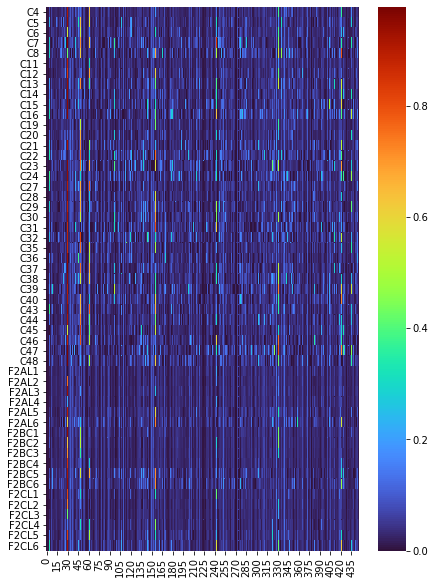

In [40]:
frag_mat = Normalize().compute_fragilitymetric(pert_mats)

fig, ax = plt.subplots(figsize=(7, 10))
sns.heatmap(frag_mat, cmap='turbo', yticklabels=raw.ch_names, ax=ax,
#            vmin=-3, vmax=3
           )

done


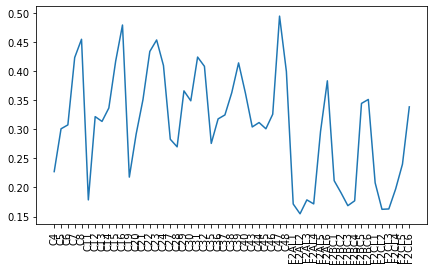

In [39]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(np.mean(frag_mat, axis=1), )
ax.set_xticks(np.arange(len(raw.ch_names)))
ax.set_xticklabels(raw.ch_names, rotation=90)
print('done')